    <table>
    <tr>
        <td><img src="./img/Macc.png" width="auto"/></td>
        <td>
            <table><tr>
            <h1 style="color:blue;text-align:center">Lógica para Ciencias de la Computación</h1></td>
            </tr></table>   
        <td>&nbsp;</td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Taller</p></tp>
            <tp><p style="font-size:150%;text-align:center">Algoritmo WalkSAT</p></tp>
            </tr></table>
        </td>
    </tr>
    </table>

---

# Objetivo <a class="anchor" id="inicio"></a>

En clase hemos visto el algoritmo walkSAT para encontrar un modelo $I$ para una fórmula $S$ en forma clausal. En este notebook implementaremos este algoritmo en Python.

Desarrollaremos la explicación mediante las siguientes secciones.

# Secciones

1. [Funciones auxiliares](#aux)
2. [Walksat](#walk)
3. [Comparación de tiempos](#comp)


# Funciones auxiliares <a class="anchor" id="aux"></a>

([Volver al inicio](#inicio))

Para poder implementar el algoritmo walkSAT requerimos algunas funciones auxiliares:

* `interpretacion_aleatoria(letrasp)`: Devuelve una interpretación seleccionando aleatoriamente el valor True o False para cada letra proposicional en `letrasp`. 

`flip_literal`$(I, \ell)$: Modifica el valor de verdad asignado por la interpretación $I$ al literal $\ell$.

In [2]:
from random import randint
from random import choice
from copy import deepcopy
from Logica import *

def interpretacion_aleatoria(letrasp):
    I = {p:randint(0,1)==1 for p in letrasp}
    return I

def flip_literal(I, l):
    p = l[-1]
    valor = False if I[p] else True
    Ip = deepcopy(I)
    Ip[p] = valor
    return Ip

In [3]:
letrasp = ['p', 'q', 'r']
I = interpretacion_aleatoria(letrasp)
I

{'p': False, 'q': False, 'r': True}

In [4]:
I = flip_literal(I, 'p')
I

{'p': True, 'q': False, 'r': True}

Para manejar la información sobre las letras proposicionales y las cláusulas de la fórmula que vayamos a trabajar, hemos definido una clase `WalkSatEstado` de la siguiente manera:

In [5]:
class WalkSatEstado():
    
    def __init__(self, S):
        self.S = S
        self.letrasp = list(set([l[-1] for C in self.S for l in C]))
        self.I = interpretacion_aleatoria(self.letrasp)
        self.I_lits = set([p for p in self.letrasp if self.I[p]] + ['-'+p for p in self.letrasp if not self.I[p]])
        self.clausulas_sat = [C for C in self.S if any((True for x in self.I_lits if x in C))]
        self.clausulas_unsat = [C for C in self.S if C not in self.clausulas_sat]

    def actualizar(self, I):
        self.I = I
        self.I_lits = set([p for p in self.letrasp if self.I[p]] + ['-'+p for p in self.letrasp if not self.I[p]])
        self.clausulas_sat = [C for C in self.S if any((True for x in self.I_lits if x in C))]
        self.clausulas_unsat = [C for C in self.S if C not in self.clausulas_sat]
       
    def SAT(self):
        return len(self.clausulas_unsat) == 0

    def break_count(self, l):
        clausulas_break_count = [C for C in self.clausulas_sat if set(C).intersection(self.I_lits)==set([l])]
        return len(clausulas_break_count)

Consideremos una fórmula en forma clausal y veamos el correspondiente objeto `WalkSatEstado`:

In [6]:
S = [['r'], ['p', '-r'], ['q', '-r'], ['-p', '-q', 'r']]
w = WalkSatEstado(S)
print("Fórmula:", S)
print("Letras proposicionales:", w.letrasp)
print("Interpretación:", w.I)
print("Literales determinados por la interpretación:", w.I_lits)
print("Cláusulas sat:", w.clausulas_sat)
print("Cláusulas unsat", w.clausulas_unsat)
print("I hace verdadera la fórmula?:", w.SAT())

Fórmula: [['r'], ['p', '-r'], ['q', '-r'], ['-p', '-q', 'r']]
Letras proposicionales: ['p', 'q', 'r']
Interpretación: {'p': False, 'q': True, 'r': True}
Literales determinados por la interpretación: {'-p', 'q', 'r'}
Cláusulas sat: [['r'], ['q', '-r'], ['-p', '-q', 'r']]
Cláusulas unsat [['p', '-r']]
I hace verdadera la fórmula?: False


Observe que esta clase tiene definido el método `break_count()` para determinar cuántas cláusulas sat se vuelven unsat si se voltea el valor de un literal:

In [7]:
w.break_count('-r')

0

---

# WalkSAT <a class="anchor" id="walk"></a>

([Volver al inicio](#inicio))

Presentamos ahora el algoritmo walkSAT.

<img src="./img/walksat.png" width="auto"/>

**Ejercicio 1:**

Implemente la función `walkSAT`.

Pruebe su respuesta con los siguientes ejemplos:

1. `S = [['r'], ['p', '-r'], ['q', '-r'], ['-p', '-q', 'r']]` 

Solución:  $I\,{=}\,\{r: True, p: True, q: True\}$.

2. `S=[['s'], ['-r', '-q'], ['r', 'q'], ['p', '-s'], ['r', '-s'], ['-p', '-r', 's']]` 

Solución: $I\,{=}\,\{s: True, p: True, r: True, q: False\}$.

3. `S = [['s'], ['p','-t'], ['q','-t'], ['-p','-q','t'], ['t','-s'], ['r','-s'], ['-t','-r','s']]` 

Solución: $I\,{=}\,\{s: True, t: True, p: True, q: True, r: True\}$.

4. `S = [['p','-q'],['-p','-q'],['q','r'],['-q''-r'],['-p','-r'],['p','-r']]` 

Solución: Intento fallido.

In [20]:
from random import *

def walkSAT(A, max_flips = 1000, max_tries = 100, p=.5):
    for i in range(max_tries):
        w = WalkSatEstado(A)
        for j in range(max_flips):
            if w.SAT():
                return ("Satisfacible"), I
            else:
                C= choice(w.clausulas_unsat)
                flag_cero = False
                for x in C:
                    if w.break_count(x) == 0:
                        v = x
                        flag_cero = True
                        break
                    if not flag_cero:
                        r = random()
                        if r <= p:
                            v = choice(C)
                        else:
                            minimo = float('Inf')
                            for x in C:
                                value = w.break_count(x)
                                if value < minimo:
                                    minimo = value
                    I = flip_literal(w.I, v)
                    w.actualizar(I)
                return ("Insatisfacible", w.I)
        return None


In [21]:
S = [['r'], ['p', '-r'], ['q', '-r'], ['-p', '-q', 'r']]
walkSAT(S)

('Insatisfacible', {'p': True, 'q': False, 'r': False})

In [44]:
S = [['s'], ['-r', '-q'], ['r', 'q'], ['p', '-s'], ['r', '-s'], ['-p', '-r', 's']]
walkSAT(S)

('Satisfacible', {'p': True, 's': True, 'q': True, 'r': False})

In [10]:
S = [['s'], ['p','-t'], ['q','-t'], ['-p','-q','t'], ['t','-s'], ['r','-s'], ['-t','-r','s']]
walkSAT(S)

('Satisfacible', {'s': True, 'r': True, 'p': True, 't': True, 'q': True})

In [41]:
S = [['p','-q'],['-p','-q'],['q','r'],['-q','-r'],['-p','-r'],['p','-r']]
walkSAT(S)

('Satisfacible', {'p': False, 'q': True, 'r': False})

---

# Comparación de tiempos <a class="anchor" id="comp"></a>

([Volver al inicio](#inicio))

Comparamos los tiempos de búsqueda de modelo para fórmulas aleatorias cada vez más grandes, entre los algoritmos DPLL y walkSAT.

**Ejercicio 2:**

Incluya aquí su implementación del DPLL.

In [73]:
def dpll(S, I):
    (x,y)=unit_propagate(S, I)
    if [] in x:
        return "insatisfacible", {}
    if x == []:
        return "satisfacible", y
    l2 = (x[0])[0]
    S2 = eliminar_literal(x, l2)
    I2 = extender_I(y, l2)
    if (dpll(S2,I2))[0] == "satisfacible":
        return "satisfacible", (dpll(S2,I2))[1]
    else:
        S3 = eliminar_literal(x, complemento(l2))
        I3 = extender_I(y,complemento(l2))
        return dpll(S3,I3)

---

In [74]:
from time import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def obtiene_tiempos(fun, args, num_it=100):
    tiempos_fun = []
    for i in range(num_it):
        arranca = time()
        x = fun(*args)
        para = time()
        tiempos_fun.append(para - arranca)
    return tiempos_fun

def compara_entradas_funs(funs, nombres_funs, lista_args, N=100):
    entradas = []
    funcion = []
    tiempos = []
    lista_dfs = []
    for i, args in enumerate(lista_args):
        for j, fun in enumerate(funs):
            t = obtiene_tiempos(fun, [args], N)
            tiempos += t
            n = len(t)
            entradas += [i+1]*n
            funcion += [nombres_funs[j]]*n
        df = pd.DataFrame({'Long_entrada':entradas, 
                           'Funcion':funcion,
                           'Tiempo_prom':tiempos})
        lista_dfs.append(df)
    df = pd.concat(lista_dfs).reset_index()
    sns.lineplot(x='Long_entrada',y='Tiempo_prom',hue='Funcion',data=df)
    plt.show()

In [75]:
from random import uniform, choice
cantidad = 10
letras = [chr(i) for i in range(256, 256+cantidad)]
lista = [letras[0]]
formula = letras[0]
for p in letras[1:]:
            neg1 = '-' if uniform(0,1) > .5 else ''
            neg2 = '-' if uniform(0,1) > .5 else ''
            neg3 = '-' if uniform(0,1) > .5 else ''
            conectivo = choice(['Y','O','>'])
            if uniform(0,1) > .5:
                formula = neg1 + "(" + neg2 + formula + conectivo + neg3 + p + ")"
            else:
                formula = neg1 + "(" + neg2 + p + conectivo + neg3 + formula + ")"
            lista.append(formula)

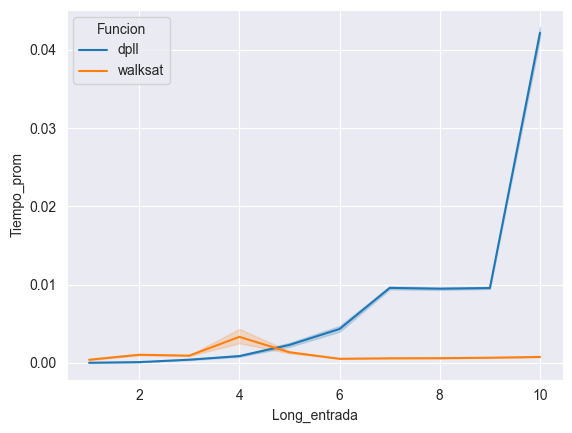

In [78]:
nombres = ['dpll', 'walksat']
sat_dpll = lambda formula: dpll(tseitin(formula), {})
sat_walksat = lambda formula: walkSAT(tseitin(formula))
funs = [sat_dpll, sat_walksat]
compara_entradas_funs(funs, nombres, lista)

Vemos que en todos los casos el DPLL es más rápido que el walkSAT.

---